# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)


In [28]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
import geopandas as gpd #For importing shapefiles
import shapely as shp #For handling shapely geometries
from shapely import vectorized # For building the idomain using vector arrays
import networkx as nx #For handling creek networks and pathways
import geojson #For handling geojson files
import imageio.v2 as imageio #For making GIFs of head distributions
from datetime import datetime, timedelta #For creating datetime timeseries for plotting
import shutil as shutil #For saving and creating directories of head plots in transient
import pygeos #For handling geographic data
from pygeos import STRtree #For handling geographic data in stringtrees

## Load External Data

Import the watershed data (HUC - 12)  
Import the Sinkhole and Spring Data  
Import the Bear Spring Discharge Data  
Import the Groundwater Elevation Data from the MRSW  
Import the Recharge Data from Zixuan

In [29]:
#Load the Watershed Extent data from USGS StreamStats
geoJSON = './data/HUC_12.geojson'
watershed = gpd.read_file(geoJSON)
projected_crs = 'EPSG:32615' #Set the projection coordinate ref. to the correct region
watershed = watershed.to_crs(projected_crs) #Set the projected CRS to the watershed polygon

#Check for geometry types (need to extract a polygon dataset)
watershed_types = watershed.geometry.type.unique()
print(f'The data types in watershed_types is: {watershed_types}')

#Generate a Polygon object from the watershed geoJSON
wsPolygon = watershed[watershed.geometry.type == 'Polygon']
#repair the geometry for any errors that make the polygon not valid
wsPolygon.loc[:,'geometry'] = wsPolygon['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {wsPolygon.is_valid}')
wsPolygon = wsPolygon.explode(index_parts=True)

#get the bounding box for the watershed polygon
bounds = wsPolygon.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Get the area of the watershed polygon
wsArea = wsPolygon['geometry'].area.sum()
print(f'Watershed area: {wsArea/1e6:.2f} Km^2')

#Import the karst feature data (UTME, UTMN, elevation data)
f = pl.Path('./data/karst_features.csv')
karst_df = pd.read_csv(f)
karst_df = karst_df.set_index("ID") #Set the index for the karst dataframe to the feature name
karst_df['Elevation_m'] = karst_df['Elevation_ft'] * 0.3048 # create a new col. with the m elevation

#Isolate the spring and sinkhole coordinates for plotting on DEM
springs = karst_df[karst_df['Type'] == 'spring' ] #get springs
sinkholes = karst_df[karst_df['Type'] == 'sink' ] #get sinkholes

#Import the sinkhole coords that have NOT been traced
untracedSinks = np.loadtxt('./data/bear_sinkholes_coords.txt')

#Import the creek data shapefile
creeks = gpd.read_file('./data/creeks_geoJSON.geojson')
creeks = creeks.to_crs(wsPolygon.crs) #Set the coordinate reference system for the shapefile
creeks = gpd.clip(creeks, wsPolygon) #Mask out all the shapefile data that is not inside of the wsPolygon

#Import the Bear Spring discharge data
f = pl.Path('./data/transient/2017_selected_discharge.csv')
obsDis_df = pd.read_csv(f, parse_dates=["DATETIME"], index_col="DATETIME")
# Convert the index to datetime, automatically handling mixed formats
obsDis_df.index = pd.to_datetime(obsDis_df.index, format='mixed')

#Get the Marion Rest Stop Well data 
f = pl.Path('./data/transient/2017_selected_MRSW_gwElev.csv')
obsGWE_df = pd.read_csv(f, parse_dates=["datetime"], index_col="datetime")
#Convert the index to datetime objects
obsGWE_df.index = pd.to_datetime(obsGWE_df.index)
#Get rid of any NaN rows produced by the data filtering outside of python
obsGWE_df.dropna(inplace=True)
obsGWE_df.replace(0, np.nan, inplace=True)

#Get the recharge from Zixuan to try (no ET)
f = pl.Path('./data/transient/2017_selected_recharge_hourly.csv')
rch_df = pd.read_csv(f,parse_dates=['DATE'], index_col='DATE')
rch_df.index = pd.to_datetime(rch_df.index) # Reset the index to be datetime objects

The data types in watershed_types is: ['Point' 'Polygon']
The polygon is Valid: 1    True
dtype: bool
min x: 552414.3972794723, min y: 4865615.877233875, max x: 561054.4101949929, max y: 4874795.869936911
Watershed area: 51.41 Km^2


Import the Springshed polygon data

In [30]:
#Import the springshed polygon data
geoJSON = './data/Bear_Springshed.geojson'
springshed = gpd.read_file(geoJSON)
projected_crs = 'EPSG:32615'
springshed = springshed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
springshed_types = springshed.geometry.type.unique()
print(f'The data tpyes in the springshed geoJSON: {springshed_types}')

#Generate a Polygon object from the watershed geoJSON
bsPolygon = springshed[springshed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
bsPolygon.loc[:,'geometry'] = bsPolygon['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {bsPolygon.is_valid}')
bsPolygon = bsPolygon.explode(index_parts=True)

#Print the area of Bear Springshed
bsArea = bsPolygon['geometry'].area.sum()
print(f'Springshed Area: {bsArea/1e6:.2f} Km^2')


The data tpyes in the springshed geoJSON: ['Polygon']
The polygon is Valid: 0    True
dtype: bool
Springshed Area: 4.63 Km^2


### Generate Helper Functions  
To be used later in the code for various purposes

In [31]:
#Get karst feature data from karst_df
def get_karst_data(ID):
    return karst_df.loc[ID].to_dict()

#Get DEM elevation data for a karst feature point
def get_cell_elev(ID):
    k_feat = get_karst_data(ID)
    i, j = sg.intersect(k_feat['UTME'], k_feat['UTMN'])
    elev = dem_grid[i,j]
    #print(f'Feature ID: {ID},row: {i}, col: {j}, DEM_elev: {elev} ')
    return elev, i, j

#Get elevations, cell i, j intersections for the structured grid with the creek
def get_creek_cells(creek, conductance = 50):
    river_cells = set() #Initialize a list of the cells where the creek meets the sg
    #iterate over the line segment of the creek shapefile
    for line in creek.geometry:
        for coord in list(line.coords): #Access each coordinate in the line for the shapefile
            x , y = coord
            i, j = sg.intersect(x,y)
            # Check if the cell is in the active domain
            if idomain[0, i, j] == 1:  # Assuming idomain is 3D (nlay, nrow, ncol)
                elev = dem_grid[i, j]
                river_cells.add((0, i, j, elev, conductance))
    return list(river_cells) 

#Establish the creek cells using a different method than that above, works better with coarse grids
def get_creek_cellsv2(creek, sg, dem_grid, idomain, conductance=50):
    river_cells = set()

    # Convert creek geometry to PyGEOS geometries
    creek_geoms = [pygeos.linestrings(line.coords) for line in creek.geometry]
    creek_tree = STRtree(creek_geoms)

    # Iterate through grid cells
    for i in range(sg.nrow):
        for j in range(sg.ncol):
            if idomain[0, i, j] == 1:  # Only check active cells
                # Get cell vertices and create a PyGEOS Polygon
                vertices = sg.get_cell_vertices(i, j)
                cell_poly = pygeos.polygons(vertices)

                # Query the spatial index for intersecting creek geometries
                intersecting_indices = creek_tree.query(cell_poly, predicate="intersects")

                # If there are intersections, record the cell
                if len(intersecting_indices) > 0:
                    elev = dem_grid[i, j]
                    river_cells.add((0, i, j, elev, conductance))

    return list(river_cells)

# def repair_missing_creek_cells(creek, sg, dem_grid, idomain, river_cells, conductance=50):
#     # Convert river_cells to a set for efficient operations
#     river_cells_set = set(river_cells)

#     # Iterate through the creek geometry
#     for line in creek.geometry:
#         creek_line = shp.geometry.LineString(line.coords)

#         # Iterate through all grid cells
#         for i in range(sg.nrow):
#             for j in range(sg.ncol):
#                 if idomain[0, i, j] == 1:  # Only check active cells
#                     vertices = sg.get_cell_vertices(i, j)
#                     cell_poly = shp.geometry.Polygon(vertices)

#                     # Find boundary-adjacent cells not already in river_cells
#                     if creek_line.intersects(cell_poly) and (0, i, j, dem_grid[i, j], conductance) not in river_cells_set:
#                         # Add missing creek cells to the set
#                         river_cells_set.add((0, i, j, dem_grid[i, j], conductance))

#     # Return as a list for consistency with the original function
#     return list(river_cells_set)


# Ensure "island" cells are deactivated using flood-fill algorithm
def remove_isolated_cells(idomain):
    for k in range(idomain.shape[0]):  # Iterate over layers
        # Label connected components of active cells
        labeled_array, num_features = scipy.ndimage.label(idomain[k] == 1)
        
        # Find sizes of each connected component
        component_sizes = np.bincount(labeled_array.ravel())
        
        # Keep only the largest connected component (or set threshold for size)
        largest_component = np.argmax(component_sizes[1:]) + 1  # Ignore 0 (inactive cells)
        
        # Deactivate isolated cells
        idomain[k][labeled_array != largest_component] = 0

#Get locations of cells in list form
nrow = None #Just to get the error to stop showing up (is defined later)
ncol = None #Just to get the error to stop showing up (is defined later)
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nrow * ncol + i * ncol + j)
    print(f'The nodes are: {nodes}')
    return nodes

#Convert from node format to cell format
def cell_from_node(linear_index, nrow = nrow, ncol = ncol):
    k = linear_index // (nrow * ncol)  # Calculate the layer index
    i = (linear_index % (nrow * ncol)) // ncol  # Calculate the row index
    j = linear_index % ncol  # Calculate the column index
    print(f'The cell Coords for node {linear_index} is {k}, {i}, {j}')
    return k, i, j

## Build the domain from the above GeoJSON, shapefiles

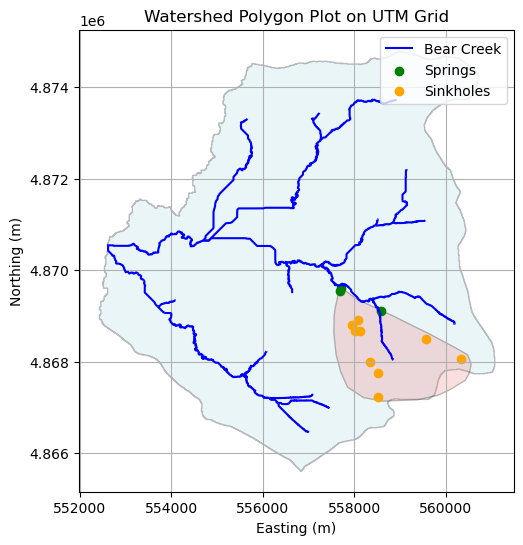

In [32]:
# Plot the polygon using the correct CRS to ensure that the bounds are in the right coordinate system and that the polygon looks correct
fig, ax = plt.subplots(figsize=(6, 6))
wsPolygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha = 0.25, label = 'Watershed Area')
bsPolygon.plot(ax=ax, color='lightcoral', edgecolor='black', alpha = 0.25, label = 'Springshed Area')
creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.legend()
plt.show()

### Combine the Watershed Polygon with the Springshed Polygon

The polygon is Valid: 0    True
dtype: bool


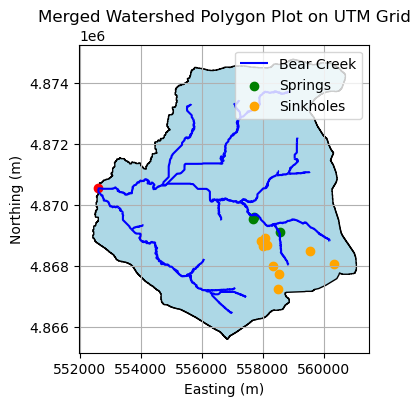

In [33]:
#Combine the polygons into a collective list
polygons = list(wsPolygon['geometry']) + list(bsPolygon['geometry'])

#Merge the polygon list into a singular polygon covering the watershed and springshed
merged = shp.ops.unary_union(polygons)

#Convert the merged polygon to a GeoDataFrame (gdf) object
wsMerged = gpd.GeoDataFrame([{'geometry': merged}], crs=projected_crs)

#repair the geometry for any errors that make the polygon not valid
wsMerged.loc[:,'geometry'] = wsMerged['geometry'].apply(shp.validation.make_valid)
print(f'The polygon is Valid: {wsMerged.is_valid}')
wsMerged = wsMerged.explode(index_parts=True)

#Plot the new domain shape from the merged polygons
label = False #Flag for turning the creek linestring labels on/off
#Plot the creek and karst feature data on the watershed
fig, ax = plt.subplots(figsize=(4, 4))
wsMerged.plot(ax=ax, color = 'lightblue', edgecolor = 'black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')

#Label each of the linestrings for the creeks GDF
if label == True:
    for _, creek in creeks.iterrows():
        creek_geom = creek['geometry']

        midpoint = creek_geom.interpolate(0.5, normalized = True)

        ax.text(midpoint.x, midpoint.y, str(creek['FID']), color='k', fontsize=12, ha='center')

plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Merged Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.scatter(552594.407, 4870544.353, color='red')
plt.legend()
plt.show()
#Get the new bounds of the merged polygon
bounds = wsMerged.total_bounds

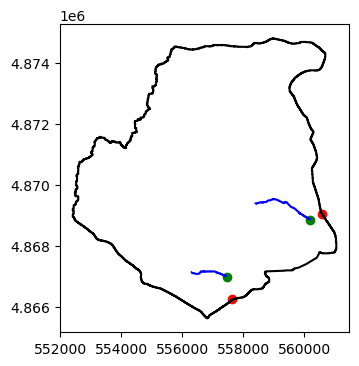

In [34]:
#Select the stream segments to extend to the watershed boundary
fids = [186, 154]
select_creeks = creeks[creeks['FID'].isin(fids)]

coords0 = list(select_creeks.iloc[0].geometry.coords)[-1]
coords0 = shp.geometry.Point(coords0)
coords1 = list(select_creeks.iloc[1].geometry.coords)[-1]
coords1 = shp.geometry.Point(coords1)

#Get the boundary for the watershed
wsBoundary = wsMerged.geometry.iloc[0].boundary

#Find the nearest points from the end of the selected creeks to the boundary
nearest0 = shp.ops.nearest_points(coords0, wsBoundary)
nearest1 = shp.ops.nearest_points(coords1, wsBoundary)
nearest_point0 = nearest0[1]
nearest_point1 = nearest1[1]

#Plot the new points
fig, ax = plt.subplots(figsize=(4, 4))
wsMerged.boundary.plot(ax=ax, color = 'k', edgecolor = 'black')
select_creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.scatter(nearest_point0.x, nearest_point0.y, color = 'red')
plt.scatter(coords0.x, coords0.y, color = 'green')
plt.scatter(nearest_point1.x, nearest_point1.y, color = 'red')
plt.scatter(coords1.x, coords1.y, color = 'green')

#Now add in the line segment connecting the
#creeks to the boundary cells nearest to them
#build new line segments
segment0 = shp.geometry.LineString([coords0, nearest_point0])
segment1 = shp.geometry.LineString([coords1, nearest_point1])

#convert line segments to geodataframe objects
segment0_gdf = gpd.GeoDataFrame(
    {'FID': [max(select_creeks['FID']) + 1]},  # Assign a unique FID
    geometry=[segment0],
    crs=select_creeks.crs  # Use the same CRS as the original creeks GeoDataFrame
)

segment1_gdf = gpd.GeoDataFrame(
    {'FID': [max(select_creeks['FID']) + 1]},  # Assign a unique FID
    geometry=[segment1],
    crs=select_creeks.crs  # Use the same CRS as the original creeks GeoDataFrame
)

### Connect the Existing Creek Boundary to the edge of the Watershed Polygon

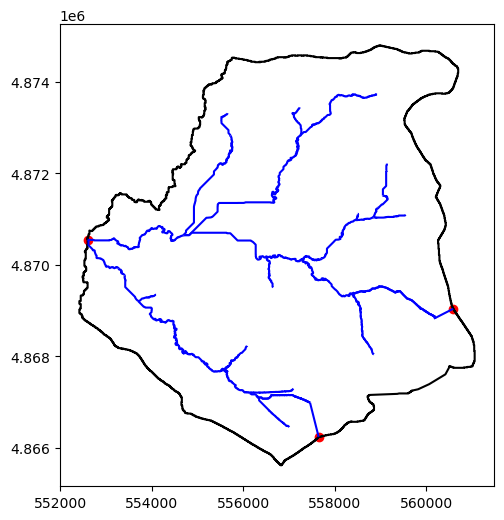

In [35]:
#Combine the creeks together with the selected creeks
new_creeks = pd.concat([select_creeks, segment0_gdf], ignore_index=True)
new_creeks = pd.concat([new_creeks, segment1_gdf], ignore_index=True)

#combine the newly made creeks with the existing creek deliniations
creeks = pd.concat([creeks, new_creeks], ignore_index=True)

#Find the intersection points where the boundary intersects with the creek
intersections = creeks.geometry.apply(lambda line: line.intersection(wsBoundary))
intersections_points = intersections[intersections.geom_type == "Point"]

unique_points = list({(point.x, point.y) for point in intersections_points})

#Plot the new creeks and the intersection points on a plot
label = False #Flag for turning the creek linestring labels on/off
fig, ax = plt.subplots(figsize=(6, 6))
wsMerged.boundary.plot(ax=ax, color = 'k', edgecolor = 'black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')
for i in range(len(unique_points)):
    plt.scatter(unique_points[i][0], unique_points[i][1], color='red')

if label == True:    
    for _, creek in creeks.iterrows():
        creek_geom = creek['geometry']

        midpoint = creek_geom.interpolate(0.5, normalized = True)

        ax.text(midpoint.x, midpoint.y, str(creek['FID']), color='k', fontsize=12, ha='center')

### Isolate the area between the Three points as the new Subdomain

[(560584.4090987638, 4869035.8773543835), (557644.4070525824, 4866235.880722723), (552594.4065552499, 4870544.35311871)]
Subdomain Area: 18.75 Km^2


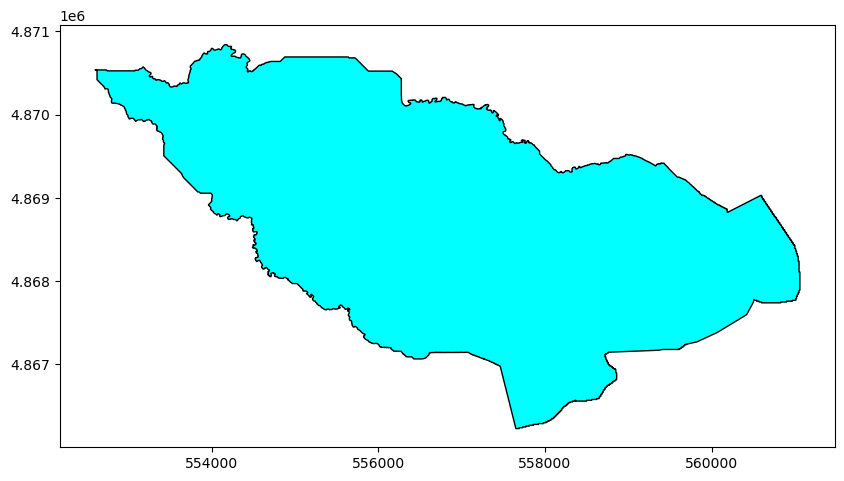

In [36]:
#Use the selected points above to generate a new domain
print(unique_points)

G = nx.Graph()
#Define a function to find the shortest path from each point through the creek network
for idx, line in creeks.iterrows():
    coords = list(line.geometry.coords)
    G.add_edge(tuple(coords[0]), tuple(coords[-1]), geometry = line.geometry)
    
#build a fxn for finding the shortest path between two points in a network
def find_shortest_path(G, start_point, end_point):
    #Find the nearest node for the start and end points
    start_node = min(G.nodes, key=lambda node: shp.geometry.Point(node).distance(start_point))
    end_node = min(G.nodes, key=lambda node: shp.geometry.Point(node).distance(end_point))
    
    #find the shortest path between these nodes
    path = nx.shortest_path(G, source=start_node, target=end_node)
    return path

#Convert the coordinate tuples to point objects
points = [shp.geometry.Point(coords) for coords in unique_points]

#find shortest path along creeks
pathAC = find_shortest_path(G, points[0], points[2])
pathBC = find_shortest_path(G, points[1], points[2])

#Convert these paths (sets of nodes) into LineStrings
linesAC = [G.edges[pathAC[i], pathAC[i + 1]]['geometry'] for i in range(len(pathAC) - 1)]
linesBC = [G.edges[pathBC[i], pathBC[i + 1]]['geometry'] for i in range(len(pathBC) - 1)]

#Merge these lines into continuous paths
AC = shp.ops.linemerge(linesAC)
BC = shp.ops.linemerge(linesBC)

#Get the domain boundary along the watershed boundary
# Convert LineString to a list of coordinates
boundary_coords = list(wsBoundary.coords)

# Find nearest boundary coordinates for Points A and B
def find_nearest_index(coords, point):
    return np.argmin([shp.ops.Point(c).distance(point) for c in coords])

index_a = find_nearest_index(boundary_coords, points[0])
index_b = find_nearest_index(boundary_coords, points[1])

# Create two paths: clockwise and counterclockwise
if index_a < index_b:
    path1 = boundary_coords[index_a:index_b + 1]
    path2 = boundary_coords[index_b:] + boundary_coords[:index_a + 1]
else:
    path1 = boundary_coords[index_b:index_a + 1]
    path2 = boundary_coords[index_a:] + boundary_coords[:index_b + 1]

# Convert paths to LineStrings and select the shorter one
path1_ls = shp.geometry.LineString(path1)
path2_ls = shp.geometry.LineString(path2)

wsSegment = path1_ls if path1_ls.length < path2_ls.length else path2_ls

#Get the boundary for the creek paths developed above
#Get the projected points on the constructed lines

#AC
AC_start = AC.project(points[0])
AC_end = AC.project(points[2])
acSegment = shp.ops.substring(AC, AC_start, AC_end)

#BC
BC_start = BC.project(points[1])
BC_end = BC.project(points[2])
bcSegment = shp.ops.substring(BC, BC_start, BC_end)

#Convert to a singular shape
subDomain_coords = (
    list(acSegment.coords) +
    list(bcSegment.coords[::-1]) +
    list(wsSegment.coords[::-1])
)

#create trianlge Polygon
subDomain_poly = shp.geometry.Polygon(subDomain_coords)

#Convert to GDF object
# Plot the result
subDomain = gpd.GeoDataFrame(
    {'geometry': [subDomain_poly]},
    crs=wsMerged.crs  # Use CRS of your original data
)

subArea = subDomain['geometry'].area.sum()/1e6
print(f'Subdomain Area: {subArea:.2f} Km^2')

#subDomain is the new domain that is selected between the two creeks
# Plot
ax = subDomain.plot(color="cyan", edgecolor="black", figsize=(10, 8))
plt.show()


## Apply the subdomain above to the DEM

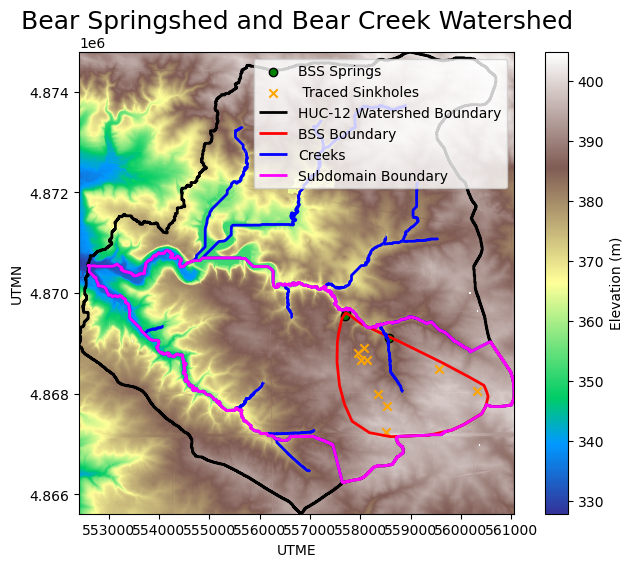

Current UTM Boundary: 552414.3972794723
Current UTM Boundary: 4865615.877233875
Current UTM Boundary: 561054.4101949929
Current UTM Boundary: 4874795.869936911


In [37]:
#Import the DEM data
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    # Define the window of useful data (in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)  # Get window boundaries to confirm they are correct
    
    # Read only the windowed portion of the DEM
    dem_data = src.read(1, window=window)
    
    # Mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_data = np.ma.masked_where(dem_data > maxval, dem_data)
    
    # Get the corresponding transform for plotting
    window_transform = src.window_transform(window)
    
#Plot DEM as a color plot to evaluate all of the values and establish the value range and units
fig, ax = plt.subplots(figsize=(8, 6))
dem_plot = ax.imshow(
    dem_data,
    cmap='terrain',
    extent=[extent[0], extent[2], extent[1], extent[3]],
    origin='upper'
)
# Add a colorbar for the DEM
cbar = plt.colorbar(dem_plot, ax=ax, label='Elevation (m)')
# Plot springs and sinkholes on the DEM
ax.scatter(
    springs['UTME'], springs['UTMN'],
    color='green', label='BSS Springs', marker='o', edgecolor='black'
)
ax.scatter(
    sinkholes['UTME'], sinkholes['UTMN'],
    color='orange', label=' Traced Sinkholes', marker='x'
)
# Overlay the merged watershed (wsMerged GeoDataFrame)
wsMerged.boundary.plot(ax=ax, color='k', linewidth=2, label='HUC-12 Watershed Boundary')
#Overlay the Springshed Area (Should be within the merged area)
bsPolygon.boundary.plot(ax=ax, color ='red', linewidth=2, label ='BSS Boundary')
#Overlay the creeks
creeks.plot(ax=ax, color= 'blue', linewidth=2, label='Creeks')
#overlay the subdomain area between the creeks
subDomain.boundary.plot(ax=ax, color= 'magenta', label= 'Subdomain Boundary', linewidth = 2)
# Add labels and title
ax.set_xlabel('UTME')
ax.set_ylabel('UTMN')
ax.set_title('Bear Springshed and Bear Creek Watershed', fontsize = 18)
ax.legend()

plt.show()

#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [38]:
#Construct a new set of bounds using the newly formed polygon
bounds = subDomain.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Re-adjust the cell size, domain of the model, ncol, nrow, based on the domain change
Lx = bounds[2] - bounds[0]
Ly = bounds[3] - bounds[1]
#delr = 50.0 #m
#delc = 50.0 #m
delr = 25.0 #m
delc = 25.0 #m
ncol = int(Lx / delc)
nrow = int(Ly / delr)

#Re-import the new DEM_Grid with the updated boundaries from the subDomain
with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    #define the window of useful data(in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)#get window boundaries to confirm they are correct
    
    #convert all of the data to a grid so it can be used with the MODFLOW model
    width = ncol#set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling= rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)

min x: 552594.4065552499, min y: 4866235.880722723, max x: 561054.4101949929, max y: 4870845.353118716


### Build Out the Modflow structured Grid

In [39]:
#generate the grid properties top, bottom, nlay, that are not defined in the grid construction above
nlay = 1
top = dem_grid #Set the upper elevation boundary for the single layer model
botm = np.ones((nlay, nrow, ncol), dtype = float) #contruct the array which will beomce the bottom array
botm_elev = 325.044 #Top of the decorah shale THIS VALUE IS NOT CORRECT, ONLY IN TEMPORARILY
#assign elevations for bottoms of the units
botm[0] = botm_elev #This will eventually be changed by the angled botm array

#Convert delc and delr to an array for input into the sg object
delr = delr * np.ones(ncol, dtype = float)
delc = delc * np.ones(nrow, dtype = float)

# Generate the model grid in flopy
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds[0],
    yoff=bounds[1],
    crs= 'EPSG:32615'
)

### Get the Coordinates for the sinkholes and the springs and store them

In [42]:
#Get all of the coordinates for the sinkholes
sinkhole_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'sink'])):
    df = karst_df[karst_df['Type'] == 'sink']
    sinkhole = df.iloc[i]
    elev, row, col = get_cell_elev(sinkhole.name)
    sinkhole_cells.append((sinkhole.name, elev, row, col))

for j in range(len(untracedSinks)):
    x = untracedSinks[j][0]
    y = untracedSinks[j][1]
    i, j = sg.intersect(x, y)
    sinkhole_cells.append(('Untraced', 0.00, i, j))

#get all of the coordinates for the springs (NOT including Bear Spring)
spring_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'spring'])):
    df = karst_df[karst_df['Type'] == 'spring']
    spring = df.iloc[i]
    elev, row, col = get_cell_elev(spring.name)
    spring_cells.append((spring.name, elev, row, col))

### Build the idomain array using vector operations  
Generally, this tends to be one of the slower steps in the model, especially at high resolution

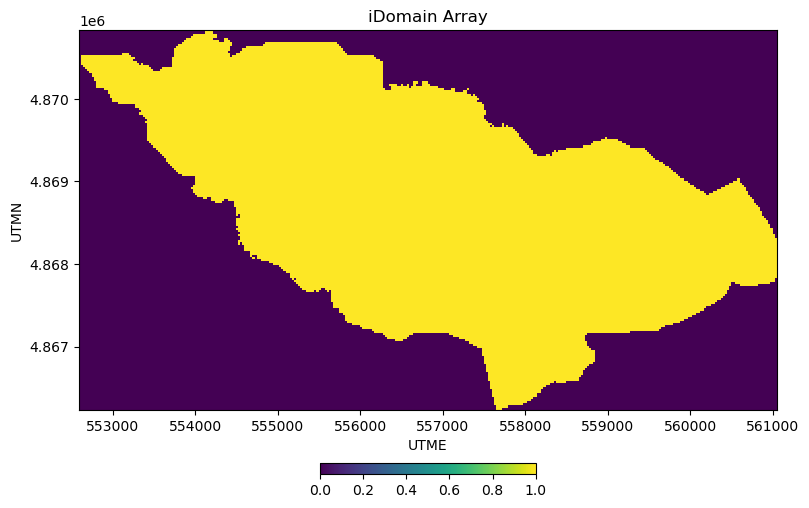

In [41]:
#idomain method based on vectorization and numpy ## This appears to be the fastsest of all the methods
xc, yc = sg.xcellcenters, sg.ycellcenters #Get the cell center coords
points = np.array([(xc[i, j], yc[i, j]) for i in range(nrow) for j in range(ncol)])

#Extract the raw polygon from the GDF object subDomain
domain = subDomain.geometry.values[0]
domain = domain.buffer(0)
gi = flopy.utils.GridIntersect(sg)
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
mask = vectorized.contains(domain, points[:, 0], points[:, 1])
idomain_mask = mask.reshape((nrow, ncol))
idomain[:, :, :] = idomain_mask.astype(int)

#Plot the idomain array for each layer of the model    
fig, ax = plt.subplots(figsize=(9,7))  # Create subplots in a single row
pmv = flopy.plot.PlotMapView(modelgrid=sg, layer=1)
cb = pmv.plot_array(idomain[0], ax=ax)
fig.colorbar(cb, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, shrink=0.8)
plt.title('iDomain Array')
plt.xlabel('UTME')
plt.ylabel("UTMN")
plt.show()

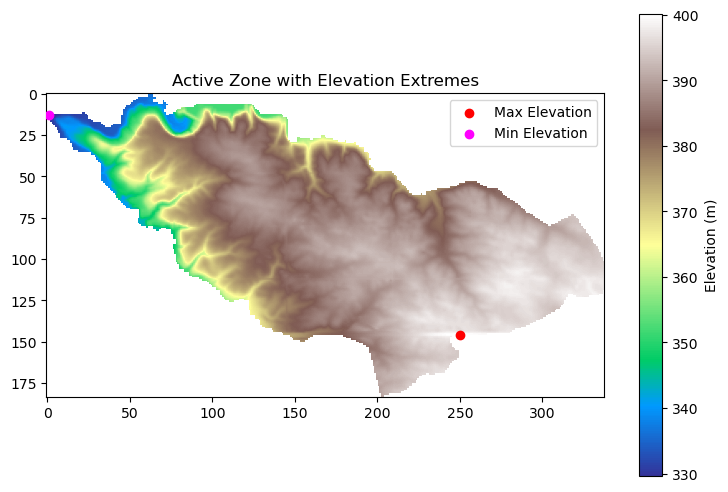

The overall surface slope of the watershed is 1.00 % to the NW
The overall slope of the watershed in degrees is 0.57 degrees
The azimuth of the slope (max elev to min elev) is 298.11 degrees


In [44]:
#Apply the DEM to the subDomain area and use it to generate a bottom array

#Calculate the slope from the highest point in the active zone to the loweset point in the active zone
# Mask the DEM for the active zone
activeDEM = np.ma.masked_where(idomain[0] == 0, dem_grid)

# Find max and min elevations within the active zone
activeMax = np.max(activeDEM)
activeMin = np.min(activeDEM)

# Get the indices of max and min elevations in the masked array
maxIndex = np.unravel_index(np.argmax(activeDEM), activeDEM.shape)
minIndex = np.unravel_index(np.argmin(activeDEM), activeDEM.shape)

# Plot the DEM with the max and min points
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
im = ax.imshow(activeDEM, cmap='terrain', origin='upper')
plt.colorbar(im, ax=ax, label='Elevation (m)')
ax.scatter(maxIndex[1], maxIndex[0], color='red', label='Max Elevation', zorder=10)
ax.scatter(minIndex[1], minIndex[0], color='magenta', label='Min Elevation', zorder=10)
ax.legend()
ax.set_title('Active Zone with Elevation Extremes')
plt.show()

#calculate the distance between these two points in m
#Get the UTME and UTMN coordinates for each of the cells
UTME1 = bounds[0] + (maxIndex[1] + 0.5) * np.average(delc)
UTME2 = bounds[0] + (minIndex[1] + 0.5) * np.average(delc)

UTMN1 = bounds[1] + (100 - maxIndex[0] + 0.5) * np.average(delr) # 100 - because the plot here counts down on the y axis
UTMN2 = bounds[1] + (100 - minIndex[0] + 0.5) * np.average(delr) # 100 - becaues the  plot here counts down on the y axis

#Calculate the distance between each point, the elevation difference, and the slope
wsH = activeMax - activeMin
wsL = np.sqrt((UTME1-UTME2)**2 + (UTMN1-UTMN2)**2)
wsSlope = wsH/wsL
print(f'The overall surface slope of the watershed is {(wsSlope* 100):.2f} % to the NW')
slopeDeg = np.arctan(wsSlope) * 180/np.pi
print(f'The overall slope of the watershed in degrees is {slopeDeg:.2f} degrees')

#determine the azimuth of the slope (to the NW)
az = np.arctan((UTME1-UTME2)/(UTMN1-UTMN2))
azDeg = az * (180/np.pi) + 360 #adding 360 because we want in azimuth convention
print(f'The azimuth of the slope (max elev to min elev) is {azDeg:.2f} degrees')

#The next step is to actually apply this azimuth and the known slope to create a bottom surface that slopes at ~1 degree in the same direction as the surface

### Build Out the Bottom Array using the bottom surface slope of the model

Max elev of the Sloped bottom array 352.044
Min elev of the sloped bottom array 256.28291220600187
CPU times: user 19.1 ms, sys: 898 µs, total: 20 ms
Wall time: 19.2 ms


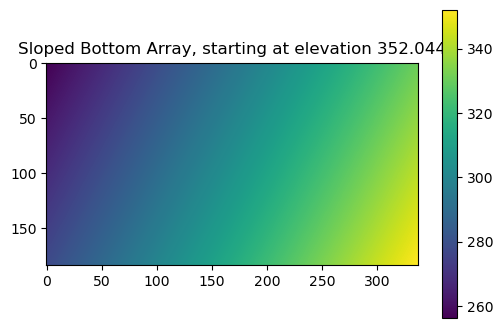

In [17]:
# Convert slope and azimuth to radians
slopeRad = np.radians(slopeDeg)
azRad = np.radians(azDeg)

#Set the max elevation that is desired
offset = 352.044

# Compute slope components in physical coordinates
slope_x = np.tan(slopeRad) * -np.sin(azRad)  # East-West component
slope_y = np.tan(slopeRad) * np.cos(azRad)  # North-South component

# Calculate physical grid dimensions
total_width = ncol * np.average(delr)  # Total width of the grid in meters
total_height = nrow * np.average(delc)  # Total height of the grid in meters

# Scale slope contributions to grid coordinates
slope_x_grid = slope_x * total_width / ncol
slope_y_grid = slope_y * total_height / nrow

# Construct the sloped surface
col_indices = np.arange(ncol)  # Columns
row_indices = np.arange(nrow)  # Rows

# Bottom Sloped array with adjusted scaling
botSloped = (offset
            - slope_x_grid * col_indices[None, :]  # x-direction slope
            - slope_y_grid * row_indices[:, None])  # y-direction slope

#Rotate the matrix into the correct orientation (there is probably a math error above but I cannot find it, so this is my solution)
botSloped = np.rot90(botSloped, 2)

print(f'Max elev of the Sloped bottom array {np.max(botSloped)}')
print(f'Min elev of the sloped bottom array {np.min(botSloped)}')

#Plot the new sloped bottom
fig, ax = plt.subplots(figsize=(6, 4))

#Plot the array as a colorplot
plot = ax.imshow(botSloped)

#Add a colorbar
plt.colorbar(plot)
plt.title(f'Sloped Bottom Array, starting at elevation {offset}')

#Use the botSloped array to replace the elvation set as the bottom of the model (botm[-1])
botm[0] = botSloped

#Use the new bottom array, as well assign new bounds to the model grid
sg.botm[0] = botm[0]   

In [45]:
#Build a 2D bresenham algorithm for identifying cell pathways.
def bres(row1, col1, row2, col2):
    """Generate cell indices along a straight line in a 2D grid using Bresenham's algorithm."""
    cells = []
    d_row = abs(row2 - row1)
    d_col = abs(col2 - col1)
    sign_row = 1 if row2 > row1 else -1
    sign_col = 1 if col2 > col1 else -1
    err = d_col - d_row

    while (row1 != row2 or col1 != col2):
        cells.append((row1, col1))
        err2 = 2 * err
        if err2 > -d_row:
            err -= d_row
            col1 += sign_col
        if err2 < d_col:
            err += d_col
            row1 += sign_row

    cells.append((row2, col2))  # Add the last cell
    return cells

#Test this out
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
#Get the elevation, cell location for 55D0000054
testelev, itest, jtest = get_cell_elev('55D54')

test_path = bres(iBS, jBS, itest, jtest)

#This method appears to work as intended, so now let's apply it to each of the sinkholes
conduit_cells = []
for p in range(len(sinkhole_cells)):
    row2 = sinkhole_cells[p][2]
    col2 = sinkhole_cells[p][3]
    lineCoords = bres(iBS, jBS, row2, col2)
    conduit_cells.append(lineCoords)

## Assign Aquifer Properties (Kcond, Kh)

In [53]:
%%time

#Assign hydraulic conductivity (K) values for each of the layers
Kh = 1.3 #m/day for the watershed outside of the springshed
Kv = 1.5 #20.00 #m/day for the watershed outside of the springshed
Kh = np.array(Kh)
Kv = np.array(Kv)
KhBPP = Kh #m/day for the springshed polygon area
KvBPP = Kh # m/day for the springshed polygon area
K11 = Kh * np.ones((nlay, nrow, ncol))
K33 = Kv * np.ones((nlay, nrow, ncol))

#Assign increased Kh and Kv values to the springshed area
#extract the raw polygon from the GDF object bsPolygon
bsdomain = bsPolygon.geometry.values[0]

# This also appears to be a bit of  a slow step, needs to be addressed for the high resolution model

ixbs = gi.intersect(bsdomain)
for i, j in ixbs["cellids"]:
    K11[0, i, j] = KhBPP

for i, j in ixbs["cellids"]:
    K33[0, i, j] = KvBPP

Kcond = 1000.0 #m/day

#THE TEXT BELOW IS WHAT IS USE TO ASSIGN THE CONDUIT CONDUCTIVITIES TO THE INDIVIDUAL CELLS
#Adjust the conductivity values for the regions with the conduits
for j in range(len(conduit_cells)):
    path = conduit_cells[j]
    #K_cond = conduit_conductivities[j]
    K_cond = Kcond
    for i in range(len(path)):
        row = path[i][0]
        col = path[i][1]
        K11[0, row, col] = K_cond

CPU times: user 3.79 s, sys: 39.5 ms, total: 3.83 s
Wall time: 3.86 s


## Build and Run the Simulation

Plot the Recharge Timeseries

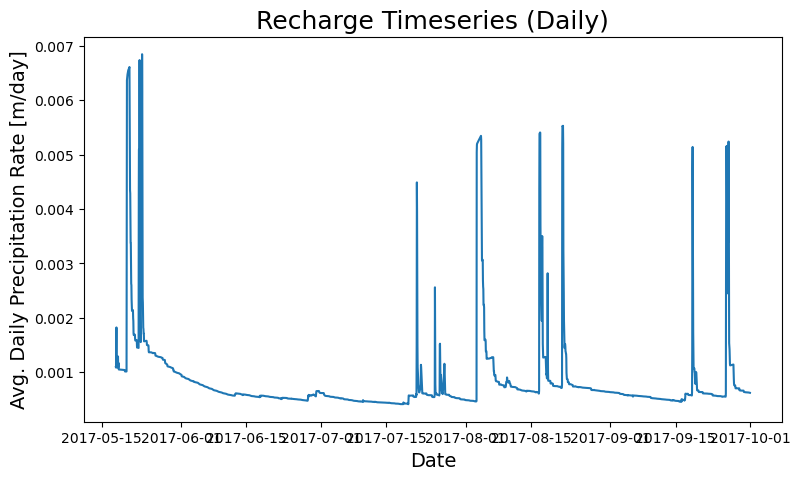

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
plt.plot(rch_df.index, rch_df['RCH[m/day]'])
plt.title('Recharge Timeseries (Daily)', fontsize = 18)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Avg. Daily Precipitation Rate [m/day]', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [54]:
%%time
#Set up the model folder where outputs will be stored
#ws = './EPM_wsgrid_transient_5m'
ws = './EPM_transient_2017'
name = 'EPM_transient'

#generate the simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    sim_ws=ws,
    exe_name='mf6',
    version = 'mf6'
)

#Build the time inputs
tuni = 'DAYS'
#nper = len(precip_avg)
nper = len(rch_df)
nstp = 1 #Number of timesteps in each stress period
perlen = 1 / 24 #length of each stress period
#perlen = 1.0 # length of each stress period
tsmult = 1.0 #Length of successive timesteps

#Generate the tdis object (starting w/ tdis set up for steady state model)
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname = "tdis",
    time_units = tuni,
    nper = nper,
    perioddata = [(perlen, nstp, tsmult) for _ in range(nper)]
)

#Create the IMS package (iterative model solver)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    inner_dvclose = 0.0001,
    outer_dvclose = 0.0001,
    linear_acceleration="BICGSTAB",
    complexity = "SIMPLE",
    print_option = "ALL",
    inner_maximum = 500,
    outer_maximum = 50
    #inner_maximum = 100,
    #outer_maximum = 10
)

#Create the groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname = name,
    save_flows = True,
    newtonoptions = 'NEWTON UNDER_RELAXATION'
)

#create the discretization package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = delr,
    delc = delc,
    top = top,
    botm = botm,
    xorigin = extent[0],
    yorigin = extent[1],
    idomain = idomain,
    length_units = 'METERS'
)

# Set up the Recharge Package
rch_spd = {i: rch_df['RCH[m/day]'][i] for i in range(nper)}
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    print_input = True,
    recharge = rch_spd,
    pname = 'RCH',
    save_flows = True
)

# #Set up the drain which will represent Bear Spring and the river
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
kBS = 0
#BS_conductance = KhBPP #m/day
BS_conductance = Kcond
BS_drain = [(kBS, iBS, jBS, BSelev, BS_conductance)] #build the Bear Spring drain list
river_drain = get_creek_cellsv2(creeks, sg, top, idomain, conductance= np.average(Kh)) #get the list of all the drain cell loations, elevs, conductances


###########################################################
##THIS IS USED TO ADDRESS AREAS WHERE THERE IS MISMATCH BETWEEN THE ACTIVE DOMAIN AND THE RIVER LOCATIONS
#Get a list of all of the cells touching the border of the model not in the river_drain list
#Pad the idomain matrix so that it works with the edge cases along the matrix boundaries
idomain_pad = np.pad(idomain[0], pad_width=1, mode= 'constant', constant_values=0)

#Get the cells along the border in a matrix
adjacent_zeros = (
    (idomain_pad[:-2, 1:-1] == 0) | #top border
    (idomain_pad[2:, 1:-1] == 0) | #bottom border
    (idomain_pad[1:-1, :-2] == 0) | #left border
    (idomain_pad[1:-1, 2:] == 0) #right border
)

border_cells = np.argwhere(idomain == 1 & adjacent_zeros)

#Filter out all the cells where there are already drains
existing_drain_cells = {(k, i, j) for k, i, j, *_ in river_drain}

unaddressed_cells = [tuple(cell) for cell in border_cells if tuple(cell) not in existing_drain_cells]
new_cells = [cell for cell in unaddressed_cells if cell[2] <= 1000]

#Create new entries for adding to the drain list
new_river_drain_entries = [
    (k, i, j, top[i, j], 1.0)
    for k, i, j in new_cells
]
#############################################################


all_creek_drains = river_drain + new_river_drain_entries
all_creek_drains = river_drain ##USE THIS WHEN WORKING WITH A LOWER GRID RESOLUTION
drnspd = BS_drain + all_creek_drains #combined list of the drain data to pass into MODFLOW DRN package ##I AM STILL HAVING ISSUES WITH THE river_drain!!

#Drain package
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data = drnspd,
    save_flows = True,
    print_flows = True
)

#initial conditions (estimated water table elevation)
wtElev = top - (382.5 - obsGWE_df.iloc[0]['gw_elev[m]'])
strt = wtElev * np.ones((nlay ,nrow , ncol))
strt[idomain == 0] = 0 #ensure the strt array is only assigned to active cells (idomain == 1))

#Set the initial conditions for the model
ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)

#node property flow package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k = K11,
    k33 = K33,
    icelltype = 0,
    save_specific_discharge = True
)

#define a specific yield value (using textbook example)
sy = 0.2

#Create the storage package (Relevant for the transient Model)
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    sy = sy
)

#set the output control module for ease of access later
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

CPU times: user 13.8 s, sys: 38.3 ms, total: 13.8 s
Wall time: 13.8 s


CPU times: user 15.9 ms, sys: 6 µs, total: 15.9 ms
Wall time: 15.4 ms


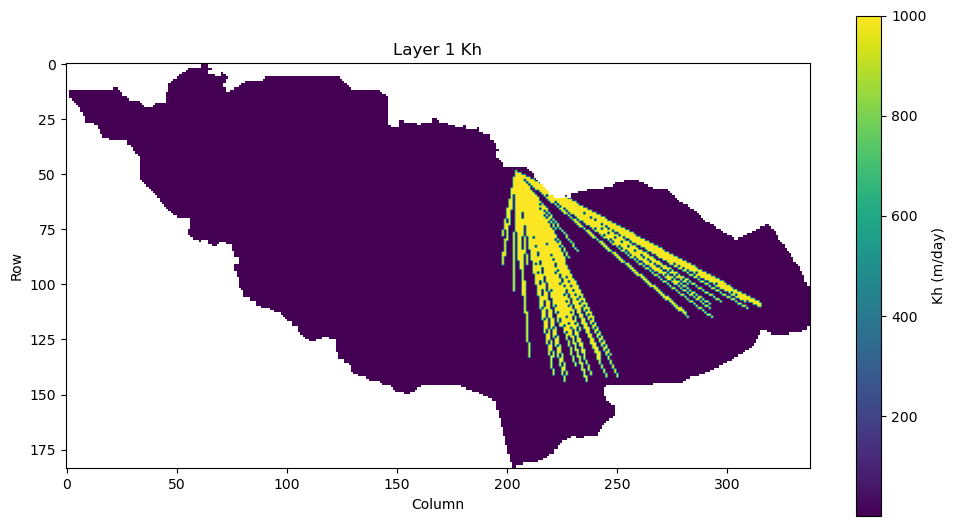

In [55]:
%%time

#Plot the Kh and Kv distributions
k11_view = npf.k.array 
k33_view = npf.k33.array

#mask out the idomain inactive cells from the array
k11_view = np.ma.masked_where(idomain == 0, k11_view)
k33_view = np.ma.masked_where(idomain == 0, k33_view)

#fig, axes = plt.subplots(2, nlay, figsize=(9, 9))
fig, ax = plt.subplots(1, nlay, figsize=(12, 6.5))


for i in range(nlay):
    ax = ax
    ax.set_title(f"Layer {i + 1} Kh")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    im = ax.imshow(k11_view[i], cmap='viridis', origin='upper')
    fig.colorbar(im, ax=ax, label = 'Kh (m/day)')
    
    #ax = axes[1]
    #im = ax.imshow(k33_view[i], cmap='jet', origin='upper')
    #ax.set_title(f"Layer {i + 1} Kv")
    #ax.set_xlabel("Column")
    #ax.set_ylabel("Row")
    #fig.colorbar(im, ax=ax, label="Kv (m/day)")


In [37]:
%%time

# write the MODFLOW input files
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_transient...
    writing model name file...
    writing package dis...
    writing package rch...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 685 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
CPU times: user 18 s, sys: 11.9 ms, total: 18 s
Wall time: 18.1 s


In [ ]:
%%time
#run the MODFLOW simulation
sim.run_simulation(silent= True) #Set silent to False if you want to print out the messages during the simulation run

## Post Process the model outputs

In [ ]:
%%time

# load the output from the simulation
head = gwf.output.head().get_alldata()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [ ]:
%%time
#Plot the first timestep to ensure that the model appears to be starting the sequence properly
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
ax = axes[0] 
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
min_head = np.min(head)
#pmv.plot_bc(ftype="CHD") 
cb = pmv.plot_array(head[0][0]) #plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.1)
#pmv.plot_vector(qx, qy, normalize=True, color="black", istep=3, jstep=3)
#pmv.contour_array(head[0][0], colors='k', linewidths = 0.75)

plt.colorbar(cb, label = "Head (m)")

# Get cell locations for Bear Creek
river_cells = [(cell[1], cell[2]) for cell in all_creek_drains]  # Extract row and column indices from river_drain
river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the Sinkholes in the model
#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the MRS Well in the model: MRSW UTME: 557091, UTMN: 4867265
welli, wellj = sg.intersect(557091, 4867265)

#Get the water table elevation at the MRSW:
MRS_head = head[0][0][welli][wellj]

#Plot the creek, spring, and sinkhole cells on the map
ax.scatter(river_x, river_y, color='blue', s=1, label = 'Bear Creek') # PLot the river_drain cells
ax.scatter(spring_x, spring_y, color='magenta', s=5, label = 'Springs') # PLot the spring_drain cells
ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=5, label = 'Sinkholes')

#Plot the location of the MRSW on the Plot
ax.scatter(557091, 4867265, color='purple', label = 'MRS Well')

ax.legend(loc = 'upper right')

#PLot an array showing in which cells the head exceeds the land surface

#Plot the locations where the hydraulic head exceeds the land surface elevation
excess_head_mask = np.zeros_like(head[0][0])
valid_mask = (head[0][0] < 1e30)  # Exclude cells with head >= 1e30
excess_head_mask[(head[0][0] > top) & valid_mask] = 1  # Mark cells with valid excess head

# Create an array to store the head difference
head_difference = np.zeros_like(excess_head_mask)  # Initialize with zeros (or np.nan if preferred)

# Record the head difference where the mask is active
head_difference = head[0][0] - top

head_difference[excess_head_mask == 0 ] = 0

# Plot the model results in the second row
ax = axes[1]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Map view plot
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
cb = pmv.plot_array(head[0][0])  # Plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.05)

# Overlay the excess head mask
#pmv.plot_array(excess_head_mask, cmap="Reds", alpha=0.5, label="Excess Head")
cbx = pmv.plot_array(head_difference, cmap = "Reds", alpha = 0.4, label = "Excess Head")

# Plot features
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
#ax.legend(loc='upper right')

plt.colorbar(cb, label="Head (m)")
plt.colorbar(cbx, label = "Excess Head (m)")



#Temporarily disable cross section plotting while using highly discretized grid
#ax = axes[1]
#ax.set_title("Cross Section")
#ax.set_aspect(10.)
#ax.set_xlabel("x")
#ax.set_ylabel("z")
#pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow*0.75)})
#pxs.plot_inactive(color_noflow="gray")
#pxs.plot_bc(ftype="CHD")
#pxs.plot_array(head, head=head)
#cb = pxs.plot_array(head, head=head)
#pxs.plot_grid(color="black", linewidth=0.05)
#plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
#plt.tight_layout()

In [ ]:
# #Save the images of head and land surface exceedence in a folder for making GIFs with
output_folder = pl.Path(ws) / 'head_plots'
#output_folder.mkdir(parents=True, exist_ok=True)

# Clear the folder if it exists
if output_folder.exists():
    for item in output_folder.iterdir():
        if item.is_file():
            item.unlink()  # Remove file
        elif item.is_dir():
            shutil.rmtree(item)  # Remove directory and its contents

# Ensure the folder is recreated
output_folder.mkdir(parents=True, exist_ok=True)
#Reload the Head Data
head = gwf.output.head().get_alldata()

fig_interval = 12 #Number of hours between successive figures

startDate = datetime(2020, 5, 1)

galena_Head = []
for index, head in enumerate(head):
    #Get the head at every timestep (Not just at the start of each SPD)
    #Get the water table elevation at the MRSW:
    MRS_head = head[0][welli][wellj]
    
    #Record the head at the MRSW in the list to be plotted later
    galena_Head.append(MRS_head)
    
    if index % fig_interval != 0:  # Skip indices that are not multiples of fig_interval
        continue
    #Create the plots of the head distribution and the error cells over the entire time of the model
    # create a plot of the model results
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    # Compute the current datetime for the figure
    elapsed_hours = index # Convert index to hours based on fig_interval
    current_time = startDate + timedelta(hours=elapsed_hours)  # Adjust from start date
    # Add title with formatted date and time
    fig.suptitle(f"Head Distribution and Exceedance - {current_time.strftime('%Y-%m-%d %H:%M')}", 
             fontsize=16, fontweight='bold')

    
    ax = axes[0] 
    ax.set_title("Map View: Head Distribution")
    ax.set_aspect(1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
    min_head = np.min(head)
    #pmv.plot_bc(ftype="CHD") 
    cb = pmv.plot_array(head) #plot the head at the start of the model
    pmv.plot_inactive(color_noflow="gray")
    #pmv.plot_grid(color="black", linewidth=0.1)
    pmv.plot_vector(qx, qy, normalize=True, color="black", istep=3, jstep=3)
    pmv.contour_array(head, colors='k', linewidths = 0.75)

    plt.colorbar(cb, label = "Head (m)")

    # Get cell locations for Bear Creek
    river_cells = [(cell[1], cell[2]) for cell in all_creek_drains]  # Extract row and column indices from river_drain
    river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
    river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

    #Get the cell locations for Bear, Bear Overflow, and Hammel Springs
    spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
    spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

    #Get the cell locations for the Sinkholes in the model
    #Get the cell locations for Bear, Bear Overflow, and Hammel Springs
    sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
    sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

    #Get the cell locations for the MRS Well in the model: MRSW UTME: 557091, UTMN: 4867265
    welli, wellj = sg.intersect(557091, 4867265)

    
    #Plot the creek, spring, and sinkhole cells on the map
    ax.scatter(river_x, river_y, color='blue', s=1, label = 'Bear Creek') # PLot the river_drain cells
    ax.scatter(spring_x, spring_y, color='magenta', s=5, label = 'Springs') # PLot the spring_drain cells
    ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=5, label = 'Sinkholes')

    #Plot the location of the MRSW on the Plot
    ax.scatter(557091, 4867265, color='purple', label = 'MRS Well')

    ax.legend(loc = 'upper right')

    #PLot an array showing in which cells the head exceeds the land surface

    #Plot the locations where the hydraulic head exceeds the land surface elevation
    excess_head_mask = np.zeros_like(head[0])
    valid_mask = (head[0] < 1e30)  # Exclude cells with head >= 1e30
    excess_head_mask[(head[0] > top) & valid_mask] = 1  # Mark cells with valid excess head

    # Create an array to store the head difference
    head_difference = np.zeros_like(excess_head_mask)  # Initialize with zeros (or np.nan if preferred)

    # Record the head difference where the mask is active
    head_difference = head[0] - top

    head_difference[excess_head_mask == 0 ] = 0

    # Plot the model results in the second row
    ax = axes[1]
    ax.set_title("Map View: Head Over Land Surface")
    ax.set_aspect(1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Map view plot
    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    cb = pmv.plot_array(head[0])  # Plot the head at the start of the model
    pmv.plot_inactive(color_noflow="gray")
    pmv.plot_grid(color="black", linewidth=0.05)

    # Overlay the excess head mask
    #pmv.plot_array(excess_head_mask, cmap="Reds", alpha=0.5, label="Excess Head")
    cbx = pmv.plot_array(head_difference, cmap = "Reds", alpha = 0.4, label = "Excess Head")

    # Plot features
    ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
    ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
    ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
    #ax.legend(loc='upper right')

    plt.colorbar(cb, label="Head (m)")
    plt.colorbar(cbx, label = "Excess Head (m)")
    
    fig.savefig(pl.Path(output_folder, f"spd_{int(index/fig_interval)}.png"))
    plt.close(fig)

# Set the output file path for the GIF
gif_path = pl.Path(output_folder) / "head_evolution.gif"

# Get a sorted list of all images
image_files = sorted(output_folder.glob("spd_*.png"), key=lambda x: int(x.stem.split("_")[1]))

# Read images and save as GIF
images = [imageio.imread(img) for img in image_files]
imageio.mimsave(gif_path, images, format= 'GIF' , duration=0.5)  # Adjust duration for speed control

In [ ]:
#Calculate the discharge from Bear Spring

#Get the Bear Spring Coordinates
print(f'The Coordinates for Bear Spring are:{kBS, iBS, jBS}')

#get the discharge from the BS drain and River drains
cbb_file = f"{ws}/{name}.bud"
cbb = flopy.utils.CellBudgetFile(cbb_file, precision = 'double')

#Get all of the drain data from the cbb
drn_discharge = cbb.get_data(text='DRN') #retrieve all of the DRN flows

disch_array = np.array(drn_discharge) #convert the nested array to a format where it can actually be read

#calculate the total discharge through bear spring over the entire model, units of L**3
BS_m3 = 0
for i in range(len(disch_array[:,0])): #Bear Spring is the 0th index in the drn_array
    BS_m3 = BS_m3 + disch_array[:,0][i][2] * -1
BS_m3 = BS_m3 / 24 # ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is less)
print(f"Total Bear Spring Discharge: {BS_m3:.0f} m³")

#Bear Creek Drain Cells total discharge
BC_m3 = 0 #Initialize the total discharge sum

# Loop over all timesteps (720 timesteps)
for i in range(np.shape(disch_array)[0]):  # Iterate over   timesteps (rows of drn_array)
    # Loop over all drains, skipping the 0th drain
    for n in range(1, np.shape(disch_array)[1]):  # Start at n=1 to skip the 0th drain
        # Access the discharge value (3rd element of the tuple)
        BC_m3 += abs(disch_array[i, n][2])  # Add the absolute discharge value
        
BC_m3 = BC_m3 / 4 #ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is less)   

# Print the total discharge in cubic meters (m³)
print(f"Total Bear Creek Discharge: {BC_m3:.0f} m³")
total_drain = BC_m3 + BS_m3
print(f"Total System Discharge: {total_drain:.0f} m³")

#Get the head value in the cell that is asssociated with the Galena MRS well to use as an additional calibration check point
print(f'The Water Table Elevation in the MRS well is: {MRS_head} m')
print(f'The Depth to water in the MRS well is: {top[welli][wellj]-MRS_head} WRONG IN TRANSIENT')

In [ ]:
#Plot the discharge timeseries produced by the model

####OBSERVATION ON 1/28/25: This is really interesting, the peak in the model is MUCH less
###Than the peak in the observed data, I am curious if, with the averaged precipitation input (daily SPD)
## IF this peak signal is getting lost a bit. Someting to look into/ consider


#Get the actual observed timeseries
obsDis_df['Q[m3/day]'] = obsDis_df['Discharge[m3/s]'] * 86400 #create a column using m3/day units

tstep = nstp #Hours

#Resample the dataframe to match the tstep intervals created by the MF model
print(f'The number of steps in each stress period is: {nstp}, which translates to {tstep} hours per timestep')
dis_avg = obsDis_df.resample(f'{tstep}h').mean() #Average the daily values

#precipitation = precip_df.resample(f'{tstep}h').mean() * -1 #Negative to make them plot from top down

bearDis = disch_array[:, 0]['q'] * -1

creekDis = disch_array[:, 1:]['q'].sum(axis=1) * -1

datetimes = pd.date_range(start='05/18/2017 00:00', end="09/30/2017 23:45", freq=f"{tstep}h").to_list()

#precipitation.iloc[np.argmin(precipitation['PRCP'])]
dis_avg.iloc[np.argmax(dis_avg['Q[m3/day]'])]


print('The Elevation of the MRSW is 382.5 m above NAVD88')
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12,9))
ax = axes[0]
ax.scatter(datetimes, bearDis, label = 'Modeled Discharge', s = 5)
ax.set_title('Bear Spring Discharge')
ax.set_xlabel('Datetime')
ax.set_ylabel('Discharge, m^3/day')
ax.scatter(datetimes, dis_avg['Q[m3/day]'], label = 'Observed_Discharge', s = 5)
ax.set_ylim([np.min(dis_avg['Q[m3/day]']) - 10000.0, np.max(dis_avg['Q[m3/day]']) + 10000.0])

# Plot precipitation as downward bars
#ax2 = ax.twinx()
#ax2.bar(datetimes, precipitation['PRCP'] , color='b', width=0.1, align='center', label = 'precipitation')
ax.legend(loc = 'best')

ax = axes[1]
ax.scatter(datetimes, creekDis)
ax.set_title('Bear Creek Discharge')
ax.set_xlabel('Datetime')
ax.set_ylabel('Discharge, m^3/day')

ax= axes[2]
ax.scatter(obsGWE_df.index, obsGWE_df['gw_elev[m]'], label = 'observed MRSW head',  s = 5)
ax.scatter(datetimes, galena_Head, color = 'green', label=' Modeled MRSW Head',  s = 5)
#ax.set_ylabel('GW Elevation above NAVD88, m')
#ax.legend(loc='best')

fig.tight_layout()

plt.show()

In [30]:
#Temporarily stop running the code to prevent running the sensitivity analysis code below
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/users/1/souce015/.conda/envs/modflow6_HPC/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Sensitivity Analysis

In [ ]:
#KhBPP Sensitivity Analysis

# # Define ranges for sensitivity analysis
# KhBPP_values = np.linspace(200, 6000, 1000)  # 50 values between 500 and 6000
# #Kh_values = np.linspace(0.25, 13, 20)         # 50 values between 0.25 and 13 #Activate this if you want to vary the Kh values

# # Initialize arrays to store results
# BS_discharge_results = []
# BC_discharge_results = []
# discharge_output = []

# # Loop over parameter combinations
# for KhBPP in KhBPP_values:
#     #for Kh in Kh_values: Turn on this line if you also want to vary Kh in addition to KhBPP
#         #print(f"Running simulation for KhBPP={KhBPP}, Kh={Kh}") #Need to turn this off or else it will just keep printing over and over

#     # Update hydraulic conductivity values
#     K11 = Kh * np.ones((nlay, nrow, ncol))
#     K33 = Kv * np.ones((nlay, nrow, ncol))

#     for i, j in ixbs["cellids"]:
#         K11[0, i, j] = KhBPP
#         K33[0, i, j] = KvBPP

#     # Update MODFLOW model with new parameters
#     npf = flopy.mf6.ModflowGwfnpf(
#         gwf,
#         k=K11,
#         k33=K33,
#         icelltype=0,
#         save_specific_discharge=True
#     )

#     # Run the simulation
#     sim.write_simulation(silent=True)
#     success, _ = sim.run_simulation(silent=True)
#     if not success:
#         #print(f"Simulation failed for KhBPP={KhBPP}, Kh={Kh}")
#         BS_discharge_results.append(np.nan)
#         BC_discharge_results.append(np.nan)
#         continue

#     # Extract discharge results
#     cbb = flopy.utils.CellBudgetFile(f"{ws}/{name}.bud")
#     drn_discharge = cbb.get_data(text='DRN')
#     disch_array = np.array(drn_discharge)

#     #Calculate Bear Spring Discharge
#     BS_m3 = 0
#     for i in range(len(disch_array[:,0])): #Bear Spring is the 0th index in the drn_array
#         BS_m3 = BS_m3 + disch_array[:,0][i][2] * -1

#     # Calculate Bear Creek discharge
#     #Bear Creek Drain Cells total discharge
#     BC_m3 = 0 #Initialize the total discharge sum

#     # Loop over all timesteps (720 timesteps)
#     for i in range(np.shape(disch_array)[0]):  # Iterate over timesteps (rows of drn_array)
#         # Loop over all drains, skipping the 0th drain
#         for n in range(1, np.shape(disch_array)[1]):  # Start at n=1 to skip the 0th drain
#             # Access the discharge value (3rd element of the tuple)
#             BC_m3 += abs(disch_array[i, n][2])  # Add the absolute discharge value

#     #Calculate Total Discharge out of the system
#     total_drain = BC_m3 + BS_m3

#     # Store results
#     BS_discharge_results.append(BS_m3)
#     BC_discharge_results.append(BC_m3)
    
#     #discharge_output.append((KhBPP, Kh, BS_m3, total_drain)) #Turn this back on if you are also varying Kh
#     discharge_output.append(total_drain)

# # Plot results
# fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# # Spring discharge
# ax[0].plot(KhBPP_values, BS_discharge_results[:len(KhBPP_values)], marker='o', label='Bear Spring')
# ax[0].set_title("Spring Discharge Sensitivity")
# ax[0].set_xlabel("KhBPP (m/day)")
# ax[0].set_ylabel("Bear Spring Discharge (m³)")
# ax[0].legend()

# # Creek discharge
# ax[1].plot(KhBPP_values, BC_discharge_results[:len(KhBPP_values)], marker='o', label='Creek Discharge')
# ax[1].set_title("Creek Discharge Sensitivity")
# ax[1].set_xlabel("KhBPP (m/day)")
# ax[1].set_ylabel("Total Model Discharge (m³)")
# ax[1].legend()

# ax[2].plot(KhBPP_values, discharge_output[:len(KhBPP_values)], marker='o', label='Total Model Discharge')
# ax[2].set_title("Creek Discharge Sensitivity")
# ax[2].set_xlabel("KhBPP (m/day)")
# ax[2].set_ylabel("Total Model Discharge (m³)")
# ax[2].legend()


# plt.tight_layout()
# plt.show()